# [Shopee product matching](https://www.kaggle.com/competitions/shopee-product-matching/overview)

This is a dataset in which the main objective is to predict what product images are the same according to the same label group

- posting_id - the ID code for the posting.
- image - the image id/md5sum.
- image_phash - a perceptual hash of the image.
- title - the product description for the posting.
- label_group - ID code for all postings that map to the same product. Not provided for the test set.


## preparing the enviroment

In [ ]:
IMAGE_SIZE = 64
BATCH_SIZE = 64

In [ ]:
%%capture
!pip install optuna kaggle

In [ ]:
import json
import os
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import torch
from google.colab import userdata
from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision import transforms
from torchvision.models import ResNet50_Weights, resnet50, ResNet18_Weights, resnet18
from tqdm import tqdm

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# print the versions of torch
print(f"torch version: {torch.__version__}")
print(f"device: {device}")

torch version: 2.5.1+cu121
device: cuda


In [ ]:
# Pick the values from google secrets and generate the json
kaggle_username = userdata.get('KAGGLE_USERNAME')
kaggle_key = userdata.get('KAGGLE_KEY')
kaggle_json = {
  "username": kaggle_username,
  "key": kaggle_key
}

# gen str version and create the file
kaggle_json_str = json.dumps(kaggle_json)
with open("kaggle.json", "w") as outfile:
    outfile.write(kaggle_json_str)

# pick the file and put inside the correct folder
if not os.path.exists("/root/.kaggle"):
  print("Creating ~/.kaggle folder")
  !mkdir -p ~/.kaggle
  print("Moving kaggle.json to correct ~/kaggle")
  !mv kaggle.json ~/.kaggle/
  print("Making root the owner of file") # this is necessary for colab
  !chmod 600 ~/.kaggle/kaggle.json


In [ ]:
%%capture

# Download the dataset unzip it, and remove the .zip
if not os.path.exists("dataset"):
    print("Downloading the dataset...")
    !kaggle competitions download -c shopee-product-matching
    print("Creating dataset/ folder")
    !mkdir -p dataset
    print("Unzipping the dataset...")
    !unzip shopee-product-matching.zip -d dataset/
    print("Removing the zip file...")
    !rm shopee-product-matching.zip
else:
    print("Folder 'dataset' already exists. Skipping download.")

## Helper functions

In [ ]:
def show_image_from_tensor(tensor:torch.Tensor, title:str=None)-> None:
    # If the tensor is on GPU, move it to CPU
    if tensor.is_cuda:
        tensor = tensor.cpu()

    # If the tensor has a batch dimension, remove it
    if tensor.dim() == 4:
        tensor = tensor.squeeze()

    # If the tensor has 3 channels (C, H, W), permute it to (H, W, C)
    if tensor.dim() == 3 and tensor.size(0) == 3:
        tensor = tensor.permute(1, 2, 0)

    # Convert the tensor to a NumPy array for plotting
    image = tensor.numpy()

    # Handle normalization: Scale back from [-1, 1] or [0, 1] to [0, 255] if needed
    if image.min() < 0:
        image = (image + 1) / 2  # Assuming [-1, 1] range
    if image.max() <= 1:
        image = image * 255

    image = image.astype('uint8')  # Ensure it's an integer type

    # Plot the image
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

# Exploring the dataset

In [ ]:
TRAIN_CSV_FILE_PATH = "dataset/train.csv"

df_train = pd.read_csv(TRAIN_CSV_FILE_PATH)
df_train.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


In [ ]:
df_train.shape

(34250, 5)

How many labels exists in this dataset?

In [ ]:
len(df_train["label_group"].value_counts())

11014

Loading the test dataset

In [ ]:
TEST_CSV_FILE_PATH = "dataset/test.csv"

df_test = pd.read_csv("dataset/test.csv").head(10)
df_test.head()

,posting_id,image,image_phash,title
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng


In [ ]:
SAMPLE_SUBMISSION_CSV_FILE_PATH = "dataset/sample_submission.csv"

df_sample_submission = pd.read_csv(SAMPLE_SUBMISSION_CSV_FILE_PATH)
df_sample_submission.head()

,posting_id,matches
0,test_2255846744,test_2255846744
1,test_3588702337,test_3588702337
2,test_4015706929,test_4015706929


Because I wanted to see if the images are belows 224x224, may test this later

In [ ]:
# see the smallest image and the biggest image in teerms of size on
# the dataset/train_iamges, the images are in jpg
def get_image_sizes(directory:str)-> None:
    """Gets the sizes of all JPG images in a directory."""
    image_sizes = {}
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            try:
                filepath = os.path.join(directory, filename)
                image = Image.open(filepath)
                # image_sizes[filename] = os.path.getsize(filepath) #Store file size
                image_sizes[filename] = image.size  # Store image dimensions (width, height)
            except (IOError, OSError):
                print(f"Error processing image: {filename}")
    return image_sizes

image_dir = "dataset/train_images"
image_sizes = get_image_sizes(image_dir)


if image_sizes:
  smallest_image = min(image_sizes, key=image_sizes.get)
  largest_image = max(image_sizes, key=image_sizes.get)

  print(f"Smallest image (by file size): {smallest_image}, Size: {image_sizes[smallest_image]} bytes")
  print(f"Largest image (by file size): {largest_image}, Size: {image_sizes[largest_image]} bytes")
else:
  print("No JPG images found in the specified directory.")

Smallest image (by file size): 9519dc286cc2d776b1dd04580ad81f0a.jpg, Size: (100, 100) bytes
Largest image (by file size): e6f609335e5d0cda4203063c70f5716a.jpg, Size: (5000, 5000) bytes


# Prepare the dataset for training

Question: Why use `mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]` instead of `mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]`?

Answer: This is based on the [ImageNet](https://en.wikipedia.org/wiki/ImageNet) was convencioned to be used

Because the dataset does not respect the strucute of `datasets.ImageFolder`, we need to create a custom one

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, csv_file:str,images_path:str, transform=None):
        self.data = pd.read_csv(csv_file)
        self.images_path = images_path
        self.transform = transform
        # Create a mapping from label_group to a unique class index
        self.classes = {label: idx for idx, label in enumerate(self.data['label_group'].unique())}

        # Map each label_group in the dataset to its numerical class
        self.labels = self.data['label_group'].map(self.classes).tolist()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
        # Check if idx is a list or tuple (indicating a batch)
        if isinstance(idx, (list, tuple)):
            # If idx is a batch, process each index individually
            return [self._get_single_item(i) for i in idx]
        else:
            # If idx is a single index, process as before
            return self._get_single_item(idx)

    def _get_single_item(self, idx):
        """Helper function to process a single item."""
        dataset_path = Path(self.images_path)
        img_path = dataset_path / self.data.iloc[idx, 1] # Changed to iloc
        image = Image.open(img_path).convert('RGB')  # Ensure RGB format

        # Get label
        label = self.labels[idx]

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Define transformations for the images
data_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [ ]:
# Create custom dataset
dataset = CustomDataset(csv_file=TRAIN_CSV_FILE_PATH,images_path="dataset/train_images", transform=data_transform)

In [ ]:
min(dataset.labels), max(dataset.labels)

(0, 11013)

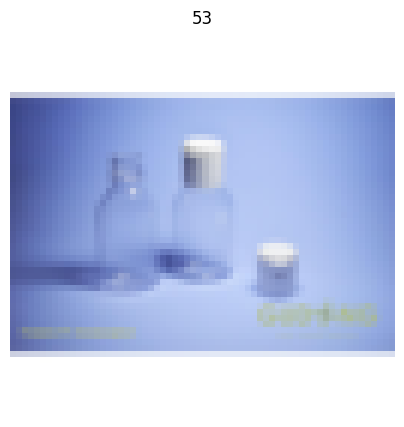

In [ ]:
image, label = dataset[55]
show_image_from_tensor(image, label)

## Split into train, validation, and test sets

Lets work with 30% of the dataset, because the full dataset takes too long to train

In [ ]:
subset_size = int(0.1 * len(dataset))
subset_indices = torch.randperm(len(dataset))[:subset_size]
subset = Subset(dataset, subset_indices)

# Now calculate the sizes of the train/val/test splits from the subset
train_size = int(0.8 * len(subset))
val_size = int(0.1 * len(subset))
test_size = len(subset) - train_size - val_size

# Split the subset into train/val/test
train_dataset, val_dataset, test_dataset = random_split(subset, [train_size, val_size, test_size])

# You can now create DataLoaders for each split

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


## Experimenting with the models
The models available on pytorch [here](https://pytorch.org/vision/main/models.html#table-of-all-available-classification-weights)

- ViT
- resnet
- EfficientNet

Question: Which parameters can I use to transfer learn faster?

Question: Whats the difference in using pretrained model and picking the weights?

```python
# using pretrained model
resnet50 = models.resnet50(pretrained=True)

# picking the weights
weights = ResNet50_Weights.DEFAULT
model = resnet50(weights=weights)
```

Answer: Simply a old way of calling the method

### resnet

In [ ]:
# Load a pretrained model (e.g., ResNet)
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

# Modify the final layer to match your dataset's number of classes
num_classes = len(dataset.classes)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

In [ ]:
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
model.to(device)

# Training loop
for epoch in range(10):  # Adjust the number of epochs as needed
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

ValueError: Location based indexing can only have [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array] types